# Some Experiments
used for some shit

## Imports

In [62]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [63]:
from datetime import datetime
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from copy import deepcopy as dc

# own classes
from utilities import save_unscaled_sequential_data, load_sequential_time_series, train_test_split, extract_features_and_targets_reg, extract_features_and_targets, split_data_into_sequences, Scaler, ValidationLossAccumulationCallback, accuracy
from baseline_model.LSTM import LSTMRegression, train_model, LSTMClassification
from baseline_model.TimeSeriesDataset import TimeSeriesDataset
from baseline_model.mean_regressor import MeanRegressor
from data_generation.algorithmic.brownian_motion import brownian_motion
from data_generation.algorithmic.jittering import create_jittered_time_series
from data_generation.algorithmic.time_warping import create_time_warped_data

In [64]:
DATA_FOLDER = Path("./data")
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
REAL_DATA_FOLDER = DATA_FOLDER / "real"
LOAD_ORIGINAL_DATA = False

In [65]:
traffic_le = pd.read_csv(REAL_DATA_FOLDER / "metro_interstate_traffic_volume_label_encoded_no_categorical.csv")
traffic_tw = pd.read_csv(SYNTHETIC_DATA_FOLDER / "mitv_time_warped.csv")

In [66]:
ori = traffic_le['traffic_volume'].to_numpy()

In [67]:
traffic_le.shape, traffic_tw.shape

((28511, 5), (28511, 5))

In [68]:
from tsaug import AddNoise
add_noise = AddNoise(scale=0.2)
noise = add_noise.augment(ori)

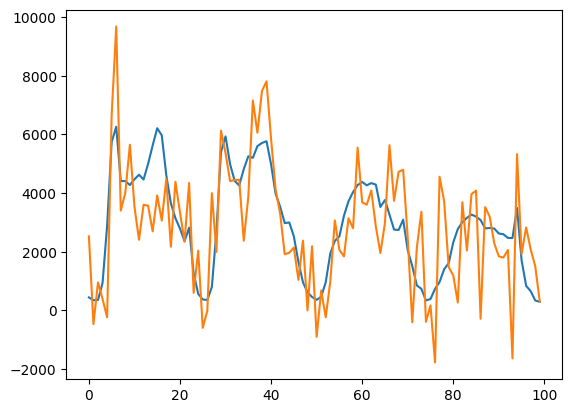

In [69]:
plt.plot(ori[:100], label='original')
plt.plot(noise[:100], label='noise')

## Time Warping

## Rescale timeGAN data

In [70]:
# save_unscaled_sequential_data(ori_data_path=REAL_DATA_FOLDER / "metro_interstate_traffic_volume_label_encoded.csv",
#                                      scaled_data_path=SYNTHETIC_DATA_FOLDER / "mitv_28499_12_11_lstm.csv",
#                                      scaled_data_shape=(28499, 12, 11),
#                                      no_features_to_inverse_scale=9)